# 1.Average different buildings by months

In [ ]:
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import numpy as np
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from itertools import combinations
import seaborn as sns
from sklearn.preprocessing import StandardScaler
# Load the data
file_path = '2023_2024_monthly_data_excel_half_zeros.xlsx'
# Get all sheet names
excel_file = pd.ExcelFile(file_path)
sheet_names = excel_file.sheet_names

# Read each sheet into a dictionary
sheets_dict = {sheet: excel_file.parse(sheet) for sheet in sheet_names}

# Define the buildings to exclude
exclude_buildings = [
    'xx', 'xxx', 'xxxxx' #...
]

# Create a list to store data for all sheets
filtered_sheets = {}
# Create a list to store data for all sheets
filtered_sheets_standardized = {}

num=0

for sheet_name, data in sheets_dict.items():
    if 'Building' in data.columns:
        data['Building_cleaned'] = data['Building'].str.extract(r'_(.*?)_summed_by_date')
        
        # exclude certain unrelated buildings
        data_filtered = data[~data['Building_cleaned'].isin(exclude_buildings)]
        
        # Exclude non-numeric columns like 'Date' and 'Building_cleaned'
        numeric_data = data_filtered.drop(columns=['Date', 'Building_cleaned'], errors='ignore')
        
        # Drop the 'Building' column and any non-numeric rows
        numeric_data_cleaned = numeric_data.drop(columns=['Building'], errors='ignore')

        # Calculate the row sum
        row_sum = numeric_data_cleaned.sum(axis=1)
        # Calculate the 25% quantile of the row sums
        avg_data = row_sum.quantile(0.1)

        # Ensure that row_sum and data_filtered align, then filter rows accordingly
        data_filtered_cleaned = data_filtered[row_sum > avg_data].reset_index(drop=True)
        
        data_filtered_cleaned= data_filtered_cleaned.drop(columns=['Date', 'Building_cleaned'], errors='ignore')

        # Group by building and calculate the average
        building_avg = data_filtered_cleaned.groupby('Building').mean()

        # Count how many rows there are
        num=num+building_avg.shape[0]

        # Add standardized and averaged data to the dictionary
        filtered_sheets_standardized[sheet_name] = building_avg

print(num)

# Select all months
selected_months = list(filtered_sheets_standardized.keys())

# Select all months的数据
selected_month_data = pd.concat(
    [filtered_sheets_standardized.get(month).assign(sheet_name=month) for month in selected_months if month in filtered_sheets_standardized]
)
    # Filter hour columns
hour_columns = [col for col in selected_month_data.columns if col.startswith("Hour_")]

normalized_data = selected_month_data[hour_columns]

# Now, if you want to save this data to a new Excel file
#output_file_path = 'Avg_filtered_data.xlsx'

# Save normalized data to an Excel file
#with pd.ExcelWriter(output_file_path) as writer:
#    normalized_data.to_excel(writer, index=False)

280


# 2. DTW Scaling and KMedoids clustering

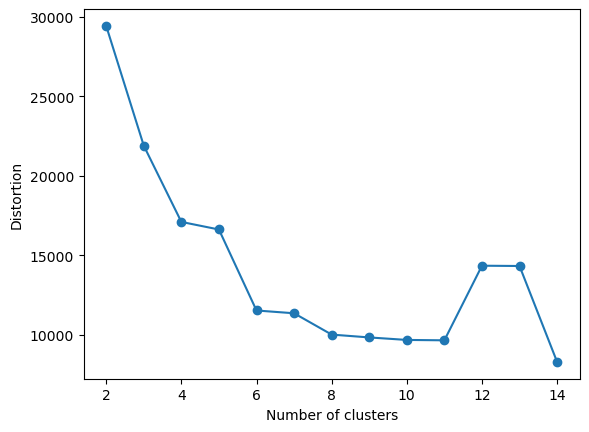

In [ ]:
import numpy as np
import pandas as pd
from sklearn_extra.cluster import KMedoids
import tslearn.metrics as metrics
from tslearn.clustering import silhouette_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# normalized_data = selected_month_data

# Calculate the Elbow plot to find the optimal number of clusters
def test_elbow():
    distortions = []
    # Compute the DTW distance matrix
    # dists = metrics.cdist_dtw(normalized_data.iloc[:, 1:].values)  # Use only the numeric part
    dists = metrics.cdist_soft_dtw_normalized(normalized_data.iloc[:, 1:].values, gamma=0.5)  # Optional soft DTW
    for i in range(2, 15):
        km = KMedoids(n_clusters=i, random_state=42, metric="precomputed")
        km.fit(dists)
        distortions.append(km.inertia_)
    
    # Plot the Elbow graph
    plt.plot(range(2, 15), distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.show()

test_elbow()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Data Shape:  (280, 24)
Cluster Prediction Shape:  (280,)
Silhouette Score:  0.6705535089624013


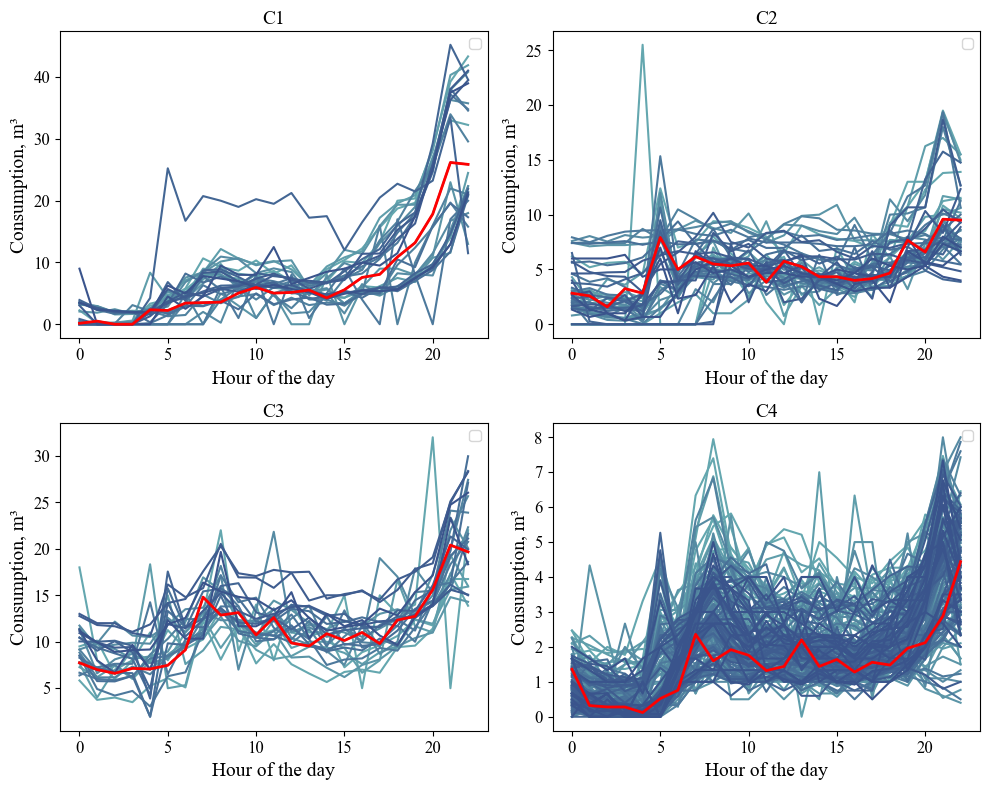

In [ ]:
import numpy as np
import pandas as pd
import tslearn.metrics as metrics
from sklearn_extra.cluster import KMedoids
from tslearn.clustering import silhouette_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import matplotlib.colors as mcolors

# Set the font globally to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

num_cluster = 4  # Assume 4 clusters are chosen
km = KMedoids(n_clusters=num_cluster, random_state=0, metric="precomputed")

# Compute the DTW distance matrix
dists = metrics.cdist_soft_dtw_normalized(normalized_data.iloc[:, 1:].values, gamma=0.5)  # Optional soft DTW

# Cluster and predict
y_pred = km.fit_predict(dists)

# Calculate the silhouette score
np.fill_diagonal(dists, 0)  # Clear the diagonal to avoid affecting silhouette score calculation
score = silhouette_score(dists, y_pred, metric="precomputed")
print("Data Shape: ", normalized_data.shape)
print("Cluster Prediction Shape: ", y_pred.shape)
print("Silhouette Score: ", score)

# Create the gradient from blue_gray (#3C6990) to #3A548C and then to #BFCDDB
cmap = mcolors.LinearSegmentedColormap.from_list("blue_gradient", ["#64A7AF", "#3A548C"], N=10)

# Visualize each cluster
plt.figure(figsize=(10, 8))  # Set a larger image size

for yi in range(num_cluster):
    plt.subplot(2, 2, yi + 1)  # Create a 2x2 subplot layout
    # Create a gradient color based on the number of lines in the cluster
    num_lines = len(normalized_data.iloc[y_pred == yi, 1:].values)
    for i, xx in enumerate(normalized_data.iloc[y_pred == yi, 1:].values):  # Exclude the first column
        color = cmap(i / num_lines)  # Use the colormap for a gradient effect
        plt.plot(xx.ravel(), color=color, alpha=1)  # The line color is a gradient

    # Plot the cluster center
    plt.plot(normalized_data.iloc[km.medoid_indices_[yi], 1:].values.ravel(), color="red", linewidth=2)  # Line color is red
    plt.text(0.5, 1.01, f'C{yi + 1}', transform=plt.gca().transAxes, fontsize=14, ha="center", va="bottom")  # Label C1, C2 above the plot
    plt.xlabel("Hour of the day", fontsize=14)  # Set the font size for the x-axis
    plt.ylabel("Consumption, m³", fontsize=14)  # Set the font size for the y-axis
    plt.legend()
    # Adjust the tick label sizes
    plt.tick_params(axis='both', labelsize=12)  # Increase the font size of the x and y axis ticks

plt.tight_layout()
plt.show()

In [ ]:
# save to excel
selected_month_data_2 = pd.concat(
    [
        data.assign(sheet_name=month) 
        for month, data in filtered_sheets_standardized.items()
        if month in selected_months
    ]
)

selected_month_data_2['Cluster'] = y_pred
selected_month_data_2.to_excel('daily_cluster_true_values_no_avg.xlsx')

# 3.Comparioson between ED and DTW scaling

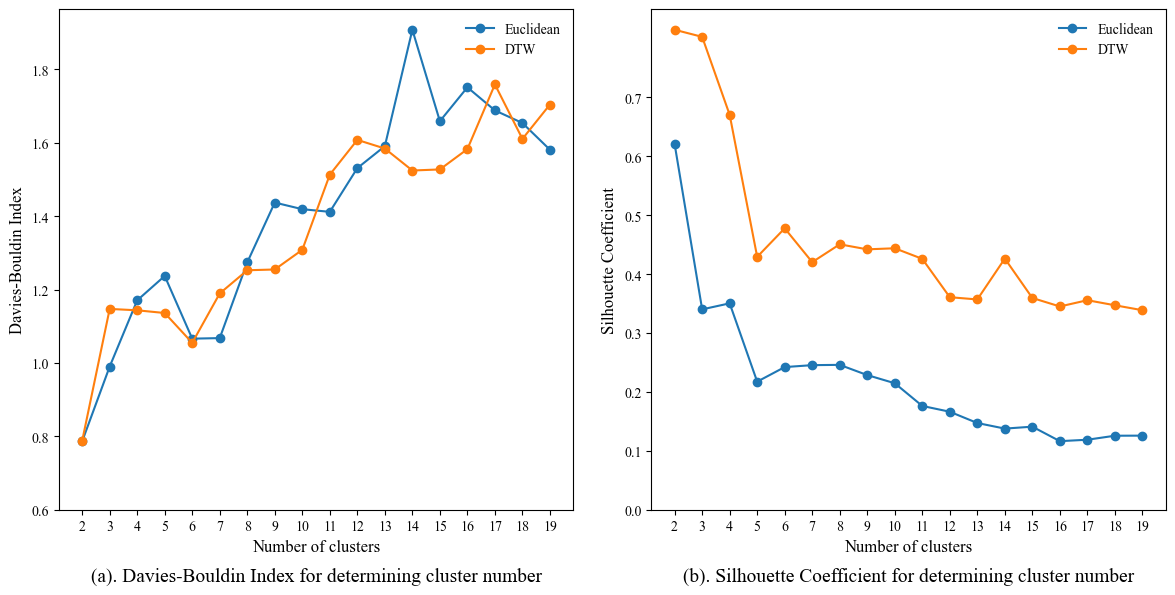

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import davies_bouldin_score, silhouette_score
from tslearn.metrics import cdist_dtw, cdist_soft_dtw_normalized

# Assuming `normalized_data` is the normalized data (in pandas DataFrame format)
# normalized_data: rows represent samples, columns represent features (e.g., time series data)
data = normalized_data.iloc[:, 1:].values  # Exclude the first column (assumed to be the ID column)

# Function to calculate metrics
def evaluate_clustering(data, distance_matrix_func, distance_name, cluster_range):
    db_scores = []
    silhouette_scores = []
    for n_clusters in cluster_range:
        # Calculate the distance matrix
        if distance_name == "ED":
            from sklearn.metrics import pairwise_distances
            dist_matrix = pairwise_distances(data, metric="euclidean")
        elif distance_name == "DTW":
            dist_matrix = distance_matrix_func(data)

        # Run KMedoids
        km = KMedoids(n_clusters=n_clusters, random_state=0, metric="precomputed")
        labels = km.fit_predict(dist_matrix)

        # Davies-Bouldin Index
        db_scores.append(davies_bouldin_score(data, labels))

        # Silhouette Coefficient
        np.fill_diagonal(dist_matrix, 0)  # Ensure the diagonal is 0
        silhouette_scores.append(silhouette_score(dist_matrix, labels, metric="precomputed"))

    return db_scores, silhouette_scores

# Define the range for the number of clusters
cluster_range = range(2, 20)

# Calculate Euclidean distance (ED)
ed_db_scores, ed_silhouette_scores = evaluate_clustering(
    data, None, "ED", cluster_range
)

# Calculate Dynamic Time Warping distance (DTW)
dtw_db_scores, dtw_silhouette_scores = evaluate_clustering(
    data, lambda x: cdist_soft_dtw_normalized(x, gamma=0.5), "DTW", cluster_range
)

# Plot the graphs
plt.figure(figsize=(12, 6))

# Davies-Bouldin Index
plt.subplot(1, 2, 1)
plt.plot(cluster_range, ed_db_scores, marker="o", label="Euclidean")
plt.plot(cluster_range, dtw_db_scores, marker="o", label="DTW")
plt.xlabel("Number of clusters", fontsize=12)
plt.ylabel("Davies-Bouldin Index", fontsize=12)
plt.xticks(np.arange(min(cluster_range), max(cluster_range) + 1, 1))  # Set x-axis to integers
plt.yticks(np.arange(0.6, 2, 0.2))  # Set y-axis grid intervals
plt.legend(frameon=False)  # Remove the legend border
plt.text(0.5, -0.15, "(a). Davies-Bouldin Index for determining cluster number", transform=plt.gca().transAxes, fontsize=14, ha="center", va="bottom")  # Title below the plot

# Silhouette Coefficient
plt.subplot(1, 2, 2)
plt.plot(cluster_range, ed_silhouette_scores, marker="o", label="Euclidean")
plt.plot(cluster_range, dtw_silhouette_scores, marker="o", label="DTW")
plt.xlabel("Number of clusters", fontsize=12)
plt.ylabel("Silhouette Coefficient", fontsize=12)
plt.xticks(np.arange(min(cluster_range), max(cluster_range) + 1, 1))  # Set x-axis to integers
plt.yticks(np.arange(0, 0.8, 0.1))  # Set y-axis grid intervals
plt.legend(frameon=False)  # Remove the legend border
plt.text(0.5, -0.15, "(b). Silhouette Coefficient for determining cluster number", transform=plt.gca().transAxes, fontsize=14, ha="center", va="bottom")  # Title below the plot

plt.tight_layout()
plt.show()
